In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input

from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))
y=y/25.0
#y

In [6]:
# Input Data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')
uvt850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')

In [7]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [8]:
t2m=t2mData.t2m.shift(time=1)
rh=rh_ds.rh.shift(time=1)
u10=u10Data.u10.shift(time=1)
v10=v10Data.v10.shift(time=1)
z=z500Data.z.shift(time=1)
t850=uvt850Data.t.shift(time=1)
u850=uvt850Data.u.shift(time=1)
v850=uvt850Data.v.shift(time=1)

In [9]:
t2mTs=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTs=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
u10Ts=u10[((u10.time.dt.month>11) | (u10.time.dt.month<2)) & (u10.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
v10Ts=u10[((v10.time.dt.month>11) | (v10.time.dt.month<2)) & (v10.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
zTs=z[((z.time.dt.month>11) | (z.time.dt.month<2)) & (z.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
t850Ts=t850[((t850.time.dt.month>11) | (t850.time.dt.month<2)) & (t850.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
u850Ts=u850[((u850.time.dt.month>11) | (u850.time.dt.month<2)) & (u850.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
v850Ts=v850[((v850.time.dt.month>11) | (v850.time.dt.month<2)) & (v850.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [10]:
t1=t2mTs.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTs.values=t1.unstack()

t1=rhTs.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTs.values=t1.unstack()

t1=u10Ts.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
u10Ts.values=t1.unstack()

t1=v10Ts.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
v10Ts.values=t1.unstack()

t1=zTs.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
zTs.values=t1.unstack()


t1=t850Ts.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t850Ts.values=t1.unstack()

t1=u850Ts.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
u850Ts.values=t1.unstack()

t1=v850Ts.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
v850Ts.values=t1.unstack()

In [11]:
z_train, z_test,t2m_train, t2m_test,t850_train, t850_test,u850_train, u850_test,v850_train, v850_test,   rh_train, rh_test,v10_train, v10_test,u10_train, u10_test,y_train,y_test = train_test_split( zTs,t2mTs,t850Ts,u850Ts,v850Ts, rhTs,v10Ts,u10Ts,y,test_size=0.20, random_state=0)

In [12]:
z_trainf, z_val,t2m_trainf, t2m_val,t850_trainf, t850_val,u850_trainf, u850_val,v850_trainf, v850_val, rh_trainf, rh_val,v10_trainf, v10_val,u10_trainf, u10_val,y_trainf,y_val = train_test_split( z_train,t2m_train,t850_train,u850_train,v850_train, rh_train,v10_train,u10_train,y_train,test_size=0.20, random_state=0)

In [13]:
t2mtrainf=t2m_trainf.values
t2mtrainf=t2mtrainf[:,:,:,None]
t2mtrainf.shape

t850trainf=t850_trainf.values
t850trainf=t850trainf[:,:,:,None]
t850trainf.shape


u850trainf=u850_trainf.values
u850trainf=u850trainf[:,:,:,None]
u850trainf.shape


v850trainf=v850_trainf.values
v850trainf=v850trainf[:,:,:,None]
v850trainf.shape

rhtrainf=rh_trainf.values
rhtrainf=rhtrainf[:,:,:,None]
rhtrainf.shape

ztrainf=z_trainf.values
ztrainf=ztrainf[:,:,:,None]
ztrainf.shape

u10trainf=u10_trainf.values
u10trainf=u10trainf[:,:,:,None]
u10trainf.shape

v10trainf=v10_trainf.values
v10trainf=v10trainf[:,:,:,None]
v10trainf.shape

(1388, 18, 26, 1)

In [14]:
ytrainf=y_trainf.values
ytrainf=ytrainf[:,None]
ytrainf.shape

(1388, 1)

In [15]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape

t850test=t850_test.values
t850test=t850test[:,:,:,None]
t850test.shape

u850test=u850_test.values
u850test=u850test[:,:,:,None]
u850test.shape


v850test=v850_test.values
v850test=v850test[:,:,:,None]
v850test.shape


rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape
u10test=u10_test.values
u10test=u10test[:,:,:,None]
u10test.shape
ztest=z_test.values
ztest=ztest[:,:,:,None]
ztest.shape

v10test=v10_test.values
v10test=v10test[:,:,:,None]
v10test.shape

(434, 18, 26, 1)

In [16]:
t2mval=t2m_val.values
t2mval=t2mval[:,:,:,None]
t2mval.shape
rhval=rh_val.values
rhval=rhval[:,:,:,None]
rhval.shape
u10val=u10_val.values
u10val=u10val[:,:,:,None]
u10val.shape
zval=z_val.values
zval=zval[:,:,:,None]
zval.shape

v10val=v10_val.values
v10val=v10val[:,:,:,None]
v10val.shape

t850val=t850_val.values
t850val=t850val[:,:,:,None]
t850val.shape

u850val=u850_val.values
u850val=u850val[:,:,:,None]
u850val.shape

v850val=v850_val.values
v850val=v850val[:,:,:,None]
v850val.shape

(348, 18, 26, 1)

In [68]:
X_test=np.array([ztest,rhtest])
X_test.shape

X_trainf=np.array([ztrainf,rhtrainf])
X_trainf.shape

X_val=np.array([zval,rhval])
X_val.shape

(2, 348, 18, 26, 1)

In [69]:
#nifti = np.random.randint(0,5,size=(508,512,513)) 
# set the last dim to 513 just to make stuff more clear
#nifti.shape
# (508, 512, 513)

X_trainf_reshape = np.einsum('lkija->klija',X_trainf)
X_trainf_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

X_val_reshape = np.einsum('lkija->klija',X_val)
X_val_reshape.shape

(348, 2, 18, 26, 1)

In [70]:
X_trainf_reshape.shape

(1388, 2, 18, 26, 1)

In [20]:
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(434, 1)

In [21]:
yval=y_val.values
yval=yval[:,None]
yval.shape

(348, 1)

In [ ]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=5, activation='relu',padding='same', input_shape=(X_trainf_reshape.shape[1],X_trainf_reshape.shape[2],X_trainf_reshape.shape[3],1)))
#model.add(MaxPooling3D())

model.add(Conv3D(filters=64, kernel_size=3, activation='relu',padding='same'))
#model.add(MaxPooling3D())
model.add(Conv3D(filters=128, kernel_size=3, activation='relu',padding='same'))

model.add(Conv3D(filters=256, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv3D(filters=512, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

#model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_trainf_reshape, ytrainf, validation_data=(X_val_reshape, yval), epochs=15)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')

Epoch 1/15
44/44 [==============================] - 78s 2s/step - loss: 3.2127 - val_loss: 0.1870
Epoch 2/15
44/44 [==============================] - 83s 2s/step - loss: 0.1780 - val_loss: 0.1343
Epoch 3/15
44/44 [==============================] - 86s 2s/step - loss: 0.1277 - val_loss: 0.1237
Epoch 4/15
44/44 [==============================] - 78s 2s/step - loss: 0.1154 - val_loss: 0.1333
Epoch 5/15
44/44 [==============================] - 114s 3s/step - loss: 0.1061 - val_loss: 0.1109
Epoch 6/15
44/44 [==============================] - 126s 3s/step - loss: 0.0970 - val_loss: 0.1101
Epoch 7/15
44/44 [==============================] - 124s 3s/step - loss: 0.0906 - val_loss: 0.1069
Epoch 8/15
44/44 [==============================] - 137s 3s/step - loss: 0.0938 - val_loss: 0.1102
Epoch 9/15
21/44 [=============>................] - ETA: 1:26 - loss: 0.0845- ETA: 1:53 -

In [74]:
X_test=np.array([rhtest])
X_test.shape

X_trainf=np.array([rhtrainf])
X_trainf.shape

X_val=np.array([rhval])
X_val.shape

(1, 348, 18, 26, 1)

In [75]:
X_trainf_reshape = np.einsum('lkija->klija',X_trainf)
X_trainf_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

X_val_reshape = np.einsum('lkija->klija',X_val)
X_val_reshape.shape

(348, 1, 18, 26, 1)

Epoch 1/10
44/44 [==============================] - 18s 356ms/step - loss: 0.3894 - val_loss: 0.1691
Epoch 2/10
44/44 [==============================] - 16s 370ms/step - loss: 0.1730 - val_loss: 0.1764
Epoch 3/10
44/44 [==============================] - 18s 418ms/step - loss: 0.1740 - val_loss: 0.1554
Epoch 4/10
44/44 [==============================] - 26s 593ms/step - loss: 0.1409 - val_loss: 0.1256
Epoch 5/10
44/44 [==============================] - 20s 443ms/step - loss: 0.1116 - val_loss: 0.1169
Epoch 6/10
44/44 [==============================] - 20s 456ms/step - loss: 0.1085 - val_loss: 0.1152
Epoch 7/10
44/44 [==============================] - 21s 469ms/step - loss: 0.0990 - val_loss: 0.1160
Epoch 8/10
44/44 [==============================] - 20s 450ms/step - loss: 0.1013 - val_loss: 0.1140
Epoch 9/10
44/44 [==============================] - 17s 396ms/step - loss: 0.0931 - val_loss: 0.1080
Epoch 10/10
44/44 [==============================] - 18s 411ms/step - loss: 0.0918 - val_lo

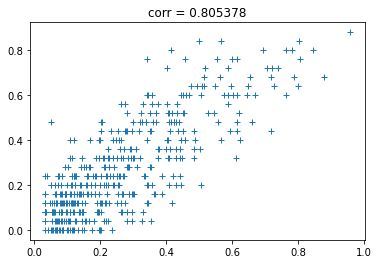

In [76]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=5, activation='relu',padding='same', input_shape=(X_trainf_reshape.shape[1],X_trainf_reshape.shape[2],X_trainf_reshape.shape[3],1)))
#model.add(MaxPooling3D())

model.add(Conv3D(filters=64, kernel_size=3, activation='relu',padding='same'))
#model.add(MaxPooling3D())
model.add(Conv3D(filters=128, kernel_size=3, activation='relu',padding='same'))

model.add(Conv3D(filters=256, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv3D(filters=512, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

#model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_trainf_reshape, ytrainf, validation_data=(X_val_reshape, yval), epochs=10)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')

In [77]:
X_test=np.array([ztest])
X_test.shape

X_trainf=np.array([ztrainf])
X_trainf.shape

X_val=np.array([zval])
X_val.shape

(1, 348, 18, 26, 1)

In [78]:
X_trainf_reshape = np.einsum('lkija->klija',X_trainf)
X_trainf_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

X_val_reshape = np.einsum('lkija->klija',X_val)
X_val_reshape.shape

(348, 1, 18, 26, 1)

Epoch 1/10
44/44 [==============================] - 23s 465ms/step - loss: 0.2670 - val_loss: 0.1694
Epoch 2/10
44/44 [==============================] - 20s 449ms/step - loss: 0.1732 - val_loss: 0.1690
Epoch 3/10
44/44 [==============================] - 21s 485ms/step - loss: 0.1695 - val_loss: 0.1686
Epoch 4/10
44/44 [==============================] - 24s 539ms/step - loss: 0.1714 - val_loss: 0.1689
Epoch 5/10
44/44 [==============================] - 21s 471ms/step - loss: 0.1740 - val_loss: 0.1718
Epoch 6/10
44/44 [==============================] - 22s 508ms/step - loss: 0.1666 - val_loss: 0.1671
Epoch 7/10
44/44 [==============================] - 20s 459ms/step - loss: 0.1697 - val_loss: 0.1656
Epoch 8/10
44/44 [==============================] - 22s 492ms/step - loss: 0.1730 - val_loss: 0.1665
Epoch 9/10
44/44 [==============================] - 20s 446ms/step - loss: 0.1689 - val_loss: 0.1645
Epoch 10/10
44/44 [==============================] - 20s 459ms/step - loss: 0.1703 - val_lo

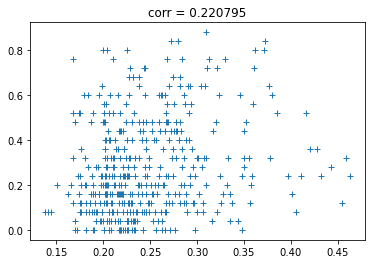

In [79]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=5, activation='relu',padding='same', input_shape=(X_trainf_reshape.shape[1],X_trainf_reshape.shape[2],X_trainf_reshape.shape[3],1)))
#model.add(MaxPooling3D())

model.add(Conv3D(filters=64, kernel_size=3, activation='relu',padding='same'))
#model.add(MaxPooling3D())
model.add(Conv3D(filters=128, kernel_size=3, activation='relu',padding='same'))

model.add(Conv3D(filters=256, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv3D(filters=512, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

#model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_trainf_reshape, ytrainf, validation_data=(X_val_reshape, yval), epochs=10)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')

In [80]:
X_test=np.array([ztest,rhtest,t2mtest])
X_test.shape

X_trainf=np.array([ztrainf,rhtrainf,t2mtrainf])
X_trainf.shape

X_val=np.array([zval,rhval,t2mval])
X_val.shape

(3, 348, 18, 26, 1)

In [81]:
X_trainf_reshape = np.einsum('lkija->klija',X_trainf)
X_trainf_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

X_val_reshape = np.einsum('lkija->klija',X_val)
X_val_reshape.shape

(348, 3, 18, 26, 1)

Epoch 1/10
44/44 [==============================] - 83s 2s/step - loss: 3.7610 - val_loss: 0.1687
Epoch 2/10
44/44 [==============================] - 81s 2s/step - loss: 0.1563 - val_loss: 0.1396
Epoch 3/10
44/44 [==============================] - 77s 2s/step - loss: 0.1218 - val_loss: 0.1237
Epoch 4/10
44/44 [==============================] - 77s 2s/step - loss: 0.1078 - val_loss: 0.1258
Epoch 5/10
44/44 [==============================] - 76s 2s/step - loss: 0.0941 - val_loss: 0.1095
Epoch 6/10
44/44 [==============================] - 71s 2s/step - loss: 0.0898 - val_loss: 0.1038
Epoch 7/10
44/44 [==============================] - 71s 2s/step - loss: 0.0844 - val_loss: 0.1147
Epoch 8/10
44/44 [==============================] - 78s 2s/step - loss: 0.0868 - val_loss: 0.1119
Epoch 9/10
44/44 [==============================] - 77s 2s/step - loss: 0.0851 - val_loss: 0.1000
Epoch 10/10
44/44 [==============================] - 89s 2s/step - loss: 0.0772 - val_loss: 0.0993


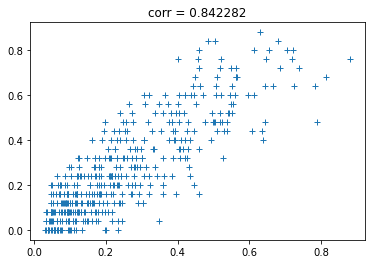

In [82]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=5, activation='relu',padding='same', input_shape=(X_trainf_reshape.shape[1],X_trainf_reshape.shape[2],X_trainf_reshape.shape[3],1)))
#model.add(MaxPooling3D())

model.add(Conv3D(filters=64, kernel_size=3, activation='relu',padding='same'))
#model.add(MaxPooling3D())
model.add(Conv3D(filters=128, kernel_size=3, activation='relu',padding='same'))

model.add(Conv3D(filters=256, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv3D(filters=512, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

#model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_trainf_reshape, ytrainf, validation_data=(X_val_reshape, yval), epochs=10)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')

In [17]:
X_test=np.array([ztest,rhtest,u10test,v10test,t2mtest])
X_test.shape

X_trainf=np.array([ztrainf,rhtrainf,u10trainf,v10trainf,t2mtrainf])
X_trainf.shape

X_val=np.array([zval,rhval,u10val,v10val,t2mval])
X_val.shape

(5, 348, 18, 26, 1)

In [18]:
X_trainf_reshape = np.einsum('lkija->klija',X_trainf)
X_trainf_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

X_val_reshape = np.einsum('lkija->klija',X_val)
X_val_reshape.shape

(348, 5, 18, 26, 1)

Epoch 1/10
44/44 [==============================] - 187s 4s/step - loss: 3.3376 - val_loss: 0.1672
Epoch 2/10
44/44 [==============================] - 182s 4s/step - loss: 0.1635 - val_loss: 0.1479
Epoch 3/10
44/44 [==============================] - 179s 4s/step - loss: 0.1354 - val_loss: 0.1225
Epoch 4/10
44/44 [==============================] - 184s 4s/step - loss: 0.1134 - val_loss: 0.1084
Epoch 5/10
44/44 [==============================] - 179s 4s/step - loss: 0.1072 - val_loss: 0.1023
Epoch 6/10
44/44 [==============================] - 186s 4s/step - loss: 0.0901 - val_loss: 0.1003
Epoch 7/10
44/44 [==============================] - 196s 4s/step - loss: 0.0876 - val_loss: 0.1068
Epoch 8/10
44/44 [==============================] - 177s 4s/step - loss: 0.0850 - val_loss: 0.1060
Epoch 9/10
44/44 [==============================] - 196s 4s/step - loss: 0.0852 - val_loss: 0.0959
Epoch 10/10
44/44 [==============================] - 179s 4s/step - loss: 0.0778 - val_loss: 0.1010


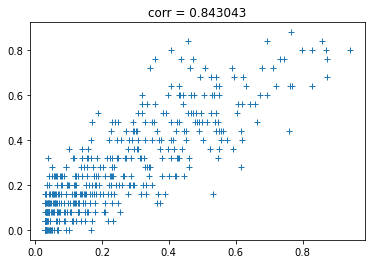

In [22]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=5, activation='relu',padding='same', input_shape=(X_trainf_reshape.shape[1],X_trainf_reshape.shape[2],X_trainf_reshape.shape[3],1)))
#model.add(MaxPooling3D())

model.add(Conv3D(filters=64, kernel_size=3, activation='relu',padding='same'))
#model.add(MaxPooling3D())
model.add(Conv3D(filters=128, kernel_size=3, activation='relu',padding='same'))

model.add(Conv3D(filters=256, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv3D(filters=512, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

#model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_trainf_reshape, ytrainf, validation_data=(X_val_reshape, yval), epochs=10)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')